# Пример с распознаванием цифр

## Overview
The complete overview and description of the Kaggle competition be found [here](https://www.kaggle.com/competitions/digit-recognizer).

The goal of the competition is to create a model that predicts which passengers survived the Titanic shipwreck.

In [3]:
# data analysis
import pandas as pd
import numpy as np

# data visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Acquire Training and Testing Data



The deatailed information regarding the features are explicitly presented [here](https://www.kaggle.com/competitions/digit-recognizer/data) in detail.

In [4]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
print(train_df.shape, test_df.shape)

(42000, 785) (28000, 784)


In [5]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
#transform data to numpy arrays (optional)
X_digits = train_df.iloc[:,1:]
Y_digits = train_df['label']

Let's have a look how these digits look. As we know, our data is encoded inside the 28x28px frames.

<Figure size 432x288 with 0 Axes>

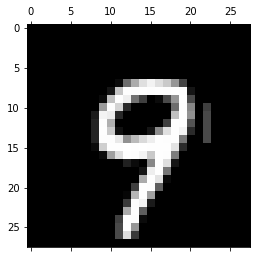

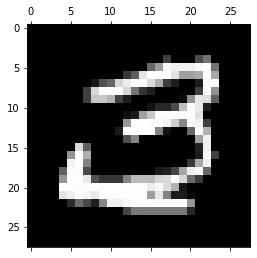

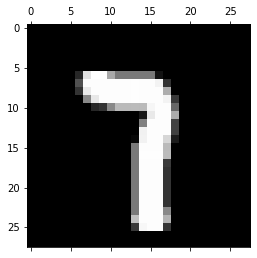

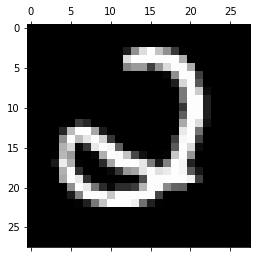

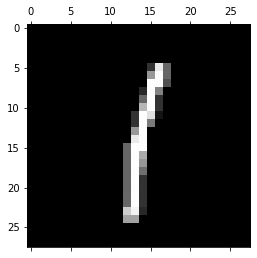

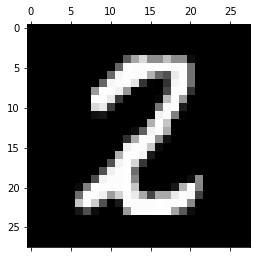

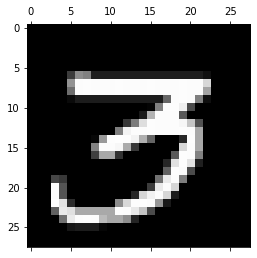

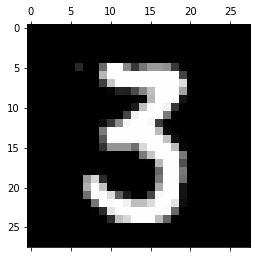

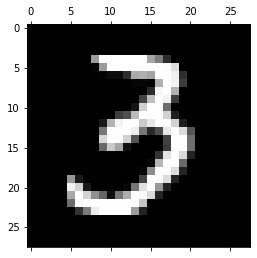

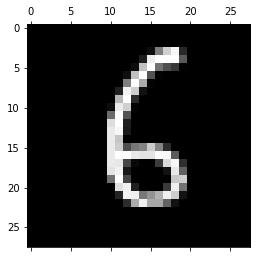

In [34]:
import random
plt.gray()
for i in range(0, 10):
    plt.matshow(np.array(X_digits.sample().squeeze()).reshape(28, 28))
    
plt.show() 

# Splitting Training Data
There is a need to split our training data into 2 subsets of training and testing data once more. Why is that? Note that the test.csv file provided is merely just a validation data for our competition submission, so it can't be treated as testing data which our current training data can learn from lest it would lead to overfitting our data.

In [36]:
from sklearn import model_selection
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X_digits, Y_digits, random_state=42)
X_test_real = test_df

# Model Generation

Now that we have completed the data preparation, we can now begin training our model and predict our solution goal. Since we are working with a given dataset with a predetermined solution goal, we are running a form of machine learning algorithm known as supervised learning. 

Models used here:
- K-Means
- Support Vector Machines
- Random Forest
- LGBMClassifier
- XGBoost

In [91]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# Defining the model algorithms for easier access
svm = SVC()
knn = KNeighborsClassifier(n_jobs=-1)
rf = RandomForestClassifier(n_jobs=-1)
lgbm = LGBMClassifier(n_jobs=-1)
xgboost = XGBClassifier(max_depth=10, min_child_weigth=20, n_jobs=-1)

MLA = [
    svm,
    knn,
    rf,
    lgbm,
    xgboost
]

row_index = 0

# Setting up the table to compare the performances of each model
MLA_cols = ['Model', 'Train Accuracy Mean', 'Test Accuracy Mean', 'Fit Time']
MLA_compare = pd.DataFrame(columns = MLA_cols)

for model in MLA:
    model_name = model.__class__.__name__
    model_fit = model.fit(X_train, Y_train)
    print(model_name, model_fit.score(X_test,Y_test)); print()
    
    Y_pred = model_fit.predict(X_test_real)
    pred = pd.DataFrame({
    "ImageId": [i[0]+1 for i in enumerate(Y_pred)],
    "Label": Y_pred
    })
    pred.to_csv('submission_{}.csv'.format(model_name), index=False)

SVC 0.9740952380952381

KNeighborsClassifier 0.9666666666666667

RandomForestClassifier 0.9639047619047619

LGBMClassifier 0.9737142857142858

[20:53:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "min_child_weigth" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


XGBClassifier 0.9699047619047619



# Tuning XGBoost
We can tune our XGBoost Classifier with [hyperopt](http://hyperopt.github.io/hyperopt/)

In [39]:
import xgboost
from sklearn.model_selection import KFold
from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

# score model with different parameters
def score(params):
    print("Training with params : ")
    print(params)
    params['n_estimators'] = int(params['n_estimators'])
    model = xgboost.XGBClassifier(**params, n_jobs=-1)
    aucs = []
    for train_idx, test_idx in cv.split(X_train):
        X_train_fold, X_test_fold = X_train.iloc[train_idx], X_train.iloc[test_idx]
        Y_train_fold, Y_test_fold = Y_train.iloc[train_idx], Y_train.iloc[test_idx]
        clf.fit(X_train_fold, Y_train_fold)
        preds = clf.predict_proba(X_test_fold)
        auc = roc_auc_score(Y_test_fold, preds[:, 1])
        aucs.append(auc)
    auc = np.mean(auc)
    result = {'loss': auc, 'status': STATUS_OK}
    print(result)
    return result


# looking for optimal parameters
def optimize(trials):
    space = {
             'n_estimators' : hp.quniform('n_estimators', 100, 1000, 5),
             'learning_rate' : hp.quniform('learning_rate', 0.025, 0.5, 0.025),
             'max_depth' : hp.quniform('max_depth', 1, 10, 1),
             'min_child_weight' : hp.quniform('min_child_weight', 1, 6, 1),
             'subsample' : hp.quniform('subsample', 0.5, 1, 0.05),
             'gamma' : hp.quniform('gamma', 0.5, 1, 0.05),
             'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05),
             'objective': 'reg:linear',
             'silent' : 1,
             'scale_pos_weight': hp.quniform('scale_pos_weight', 0.5, 10., 0.5),
             'reg_alpha': 0.0,
             'reg_lambda': 1.0
             }

    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=250)
    print('Best: ')
    print(best)

clf = xgboost.XGBClassifier()
cv = KFold(n_splits=4, shuffle=True)
trials = Trials()

optimize(trials)

Training with params :                                                                                                 
{'colsample_bytree': 1.0, 'gamma': 0.75, 'learning_rate': 0.17500000000000002, 'max_depth': 2.0, 'min_child_weight': 6.0, 'n_estimators': 725.0, 'objective': 'reg:linear', 'reg_alpha': 0.0, 'reg_lambda': 1.0, 'scale_pos_weight': 0.5, 'silent': 1, 'subsample': 0.8}
  0%|                                                                          | 0/250 [01:13<?, ?trial/s, best loss=?]


KeyboardInterrupt: 